### 1) Get stock data, trim the data.
This section of code gets the stock data, and trims the various parameters to
prepare the dataframe for processing. Also included in this section are the `verbose`
and `scale` flags. `verbose` will print some additional graphs and statistics 
and `scale` will scale our parameters; this is particularly useful if you're
utilizing LSTM, which can be magnitude sensitive (especially if you're using volume).

In [77]:
# Imports
import numpy as np
import ticker_class as tc
import matplotlib.pyplot as plt

################################################################################

# Instantiate a member of the TickerClass with the ticker you want
spy = tc.TickerClass("COIN")

# Flags
verbose = False    # Parameter to print stuff; not currently implemented
scale = False      # Parameter to scale features

########################################
# FIXME: 
# add start and end as class members?
########################################

# Retrieve data from start to end

########################################
# FIXME: 
# we should assume the user wants from the beginning to now
# unless otherwise stated. 
########################################
start = "2021-04-16"
end   = "2023-10-17"
spy.getData(start,end)

# Trim the data to get rid of excess variables; we're only interested in
# multivariate forecasting with open, high, low and close. This will be the
# basis for our training dataframe. 
trimmed_df = spy.stock_data[['Open', 'High', 'Low', 'Close']]

##########################################################
# FIXME:
# Consider using this? Also implement it. 
##########################################################
# Scaling Stuff
if scale:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler = scaler.fit(trimmed_df)
    trimmed_df_array = scaler.transform(trimmed_df)
else:
    # Scaling converts our dataframe into an array; we'll need to replicate this
    # and pop the date index for our matrix generation code to work. 
    trimmed_df_array = trimmed_df.to_numpy()

[*********************100%%**********************]  1 of 1 completed


### 2) Prepare data for training.

In this section, we construct our `x_train` and `y_train` variables, which will
be later used to train out model.

In [78]:
# Instantiate lists to be populated using formatted training data
x_train = []
y_train = []

# [DONE]
n_future = 1  # Number of days we want to look into the future based on the past days. 
              # 1 is good here; keep 1
n_past = 390   # Number of past days we want to use to predict the future. 
              # 60 is good here

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(trimmed_df_array) - n_future +1):
    x_train.append(trimmed_df_array[i - n_past:i, 0:trimmed_df_array.shape[1]])
    y_train.append(trimmed_df_array[i + n_future - 1:i + n_future, 0])

# The 0th index of x and y train are the total number of days from trimmed_df, 
# minus the amount of days we're using to predict the future. 
x_train, y_train = np.array(x_train), np.array(y_train)

# Save the dates we used to train to plot later
train_dates = trimmed_df.index[0:x_train.shape[0]]

if verbose:
    print('x_train shape == {}.'.format(x_train.shape))
    print('y_train shape == {}.'.format(y_train.shape))

### 3) Build the model

This is the exciting part; building the model! The primary hyperparameters here
are obviously the number of layers and neurons you can use in the model, as well
as the learning rate, `epochs` and `validation_split` you fit the model with. Play
around with these and see how they change the predictions! Higher fidelity models
will take significantly longer to run, however, but you may (or may not) get a better result.
The parameters are pre-tuned for the prediction of SPY, but predicting a different stock
will most likely require a new set of hyperparameters.

In [79]:
# Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# Build the Model
model = Sequential([layers.Input((x_train.shape[1], x_train.shape[2])),
                    layers.LSTM(24, return_sequences=True),
                    layers.LSTM(24, return_sequences=True),
                    layers.LSTM(24, return_sequences=True),
                    #layers.LSTM(24, return_sequences=True),
                    layers.LSTM(24),
                    layers.Dense(24, activation='relu'),
                    #layers.Dense(24, activation='relu'),
                    layers.Dense(24, activation='relu'),
                    layers.Dense(24, activation='relu'),
                    layers.Dense(1)])

# Compile and summarize the model.
model.compile(loss = 'mse', 
              optimizer = Adam(learning_rate=0.001),
              metrics = ['mean_absolute_error'])
model.summary()

# Fit the model
history = model.fit(x_train, 
                    y_train, 
                    epochs=100,
                    validation_split=0.07, # 0.007 works well
                    verbose=1)


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 390, 24)           2784      
                                                                 
 lstm_61 (LSTM)              (None, 390, 24)           4704      
                                                                 
 lstm_62 (LSTM)              (None, 390, 24)           4704      
                                                                 
 lstm_63 (LSTM)              (None, 24)                4704      
                                                                 
 dense_60 (Dense)            (None, 24)                600       
                                                                 
 dense_61 (Dense)            (None, 24)                600       
                                                                 
 dense_62 (Dense)            (None, 24)              

### 4) Visualize the model and its training metrics

After we train the model, it would be useful to see how its losses and errors
decrease, as well as how it preforms on the training data it was trained on. 
This section does just that; visualizes both the losses and the predictions our
model makes on its training data.

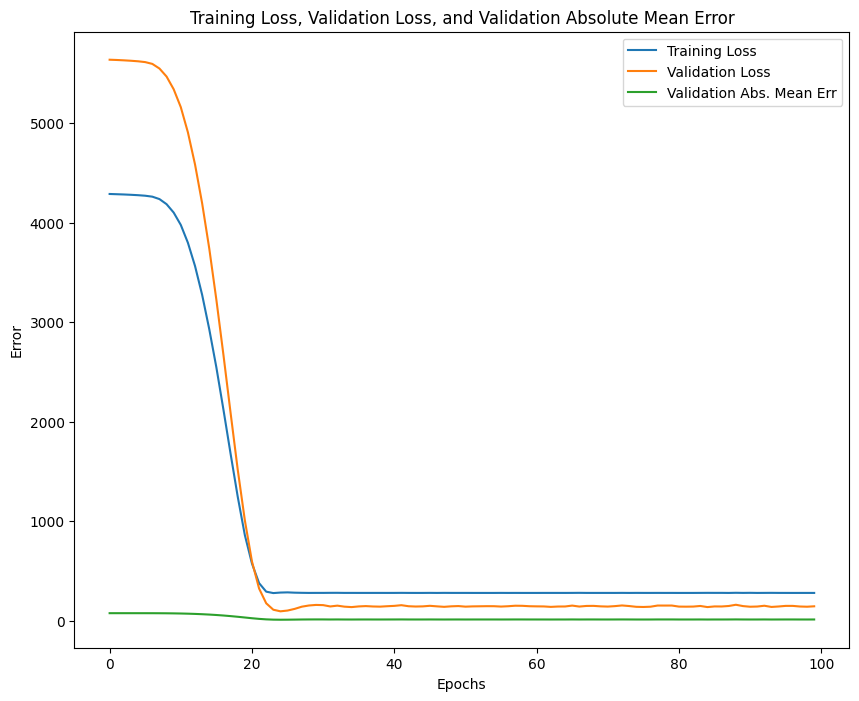

8/8 [==============================] - 1s 41ms/step


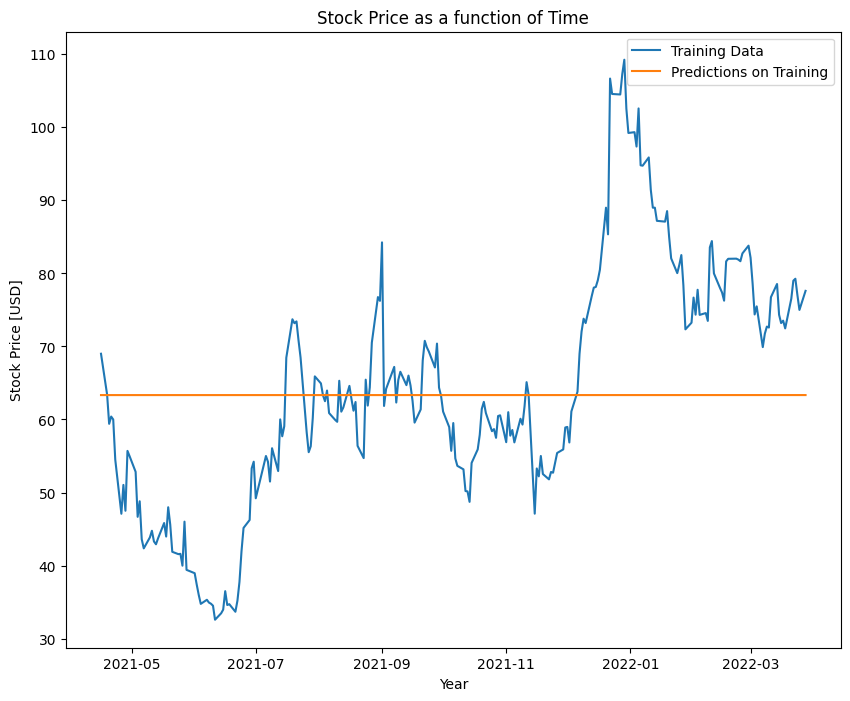

In [80]:
# Visualize training and validation loss
fig = plt.figure()
fig.set_size_inches(10, 8)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_mean_absolute_error'], label='Validation Abs. Mean Err')
plt.title('Training Loss, Validation Loss, and Validation Absolute Mean Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

# Visualize predictions on training data
fig = plt.figure()
fig.set_size_inches(10, 8)
predicitions_on_train = model.predict(x_train).flatten()
plt.plot(train_dates, y_train)
plt.plot(train_dates, predicitions_on_train)
plt.xlabel('Year')
plt.ylabel('Stock Price [USD]')
plt.title('Stock Price as a function of Time')
plt.legend(['Training Data', 'Predictions on Training'])
plt.show()

# 5) Start forecasting

In [81]:
# Imports
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import pandas as pd
import datetime as dt

# Set business days in US
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# Helper function to convert strings to datetime
def str2dt(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return dt.datetime(year=year, month=month, day=day)

# Helper function to go the other way around
def dt2str(dt):
    return dt.strftime('%Y-%m-%d')

############################################################
# FIXME
# For some reason this breaks at really weird intervals.
############################################################

# Define the number of days we wish to forecast into the future.
n_forecast_pred = 23
forecast_dates = pd.date_range(start = str2dt(end),
                               periods = n_forecast_pred, 
                               freq=us_bd).to_list()

# Forecast
forecast = model.predict(x_train[-n_forecast_pred:])

# Retrieve true data
spy_verif = tc.TickerClass("COIN")
verif_dates = pd.date_range(start = str2dt(end),
                               # +1 because download is non inclusive
                               periods = n_forecast_pred + 1, 
                               freq=us_bd).to_list()

spy_verif.getData(end, verif_dates[-1])


#############################################################################
# FIXME
# drop 11-10 because that isn't forecasted and also not in the forecast dates
# This is hardcoded; how exactly do we get around this otherwise LMFAO
#############################################################################
verif_data = spy_verif.stock_data['Close'].drop(str2dt('2023-11-10'), axis=0)


1/1 [==============================] - 0s 45ms/step
[*********************100%%**********************]  1 of 1 completed


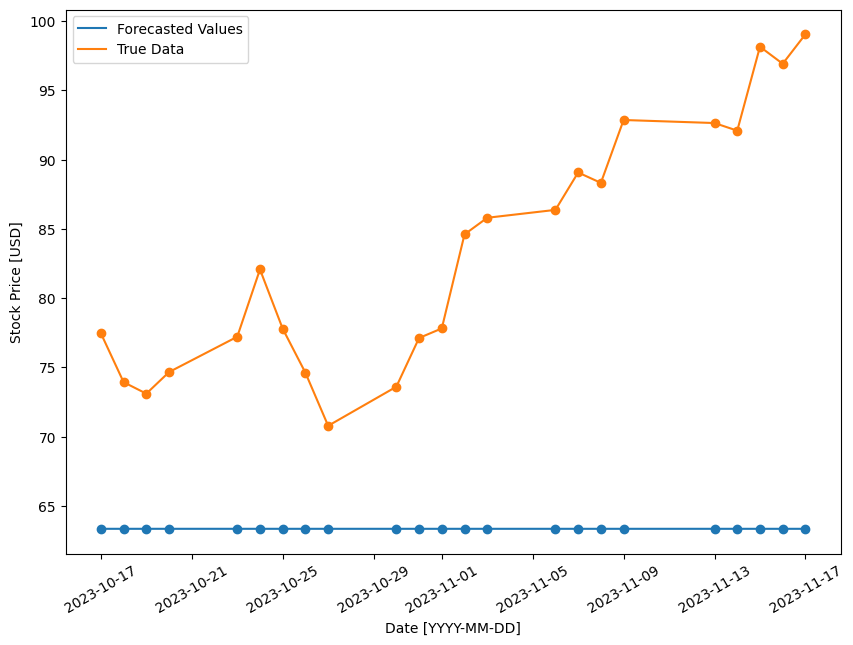

Mean Square Error:  474.5889355525509


In [82]:
# Set figure dims
fig = plt.figure()
fig.set_size_inches(10, 8)
fig.autofmt_xdate()

# Plot the true data against our forecasted data
plt.plot(forecast_dates, forecast, label='Forecasted Values')
plt.plot(forecast_dates, verif_data, label='True Data')
plt.scatter(forecast_dates, forecast)
plt.scatter(forecast_dates, verif_data)
plt.xticks(rotation=30)
plt.xlabel('Date [YYYY-MM-DD]')
plt.ylabel('Stock Price [USD]')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error
print('Mean Square Error: ', mean_squared_error(verif_data,forecast))

